# miRNA EDA
## for miRNA-Target Interactions in Cancer

## TODO: Update and test plotting code to save in GCP bucket, etc.

In [1]:
import csv
import google.datalab.storage as storage
import io
import logging
import math as m
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

## Utils

### Function definitions

In [2]:
def read_file(bucket, filepath, **kwargs):
  uri = bucket.object(filepath).uri
  get_ipython().run_line_magic('gcs', 'read --object ' + uri + ' --variable csv_data')
  return pd.read_csv(io.BytesIO(csv_data), **kwargs)

In [3]:
def save_as(temp_filename, filepath):
  !gsutil cp $temp_filename $filepath

### Set up logging

In [4]:
logger = logging.getLogger()

In [5]:
def setup_file_logger(log_file):
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)
    hdlr = logging.FileHandler(log_file)
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr) 
    logger.setLevel(logging.INFO)
    
def log(message):
  print(message)
  logger.info(message)

setup_file_logger('mirtar.log')

## Preprocess data

In [6]:
bucket = storage.Bucket('yfl-mirna')

#### Read sample miRNA expression data

In [7]:
miRNA_data = read_file(bucket, 'data/miRNA/pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.csv')

In [8]:
miRNA_data.rename(index=str, columns={'Genes': 'miRNA'}, inplace=True)
miRNA_data.columns
miRNA_data.set_index('miRNA', inplace=True)
miRNA_data['Corrected'] = (miRNA_data['Correction'] == 'Corrected')
del miRNA_data['Correction']

In [9]:
miRNA_corrections = pd.DataFrame(miRNA_data[['Corrected']])
del miRNA_data['Corrected']

In [10]:
sample_miRNAs = miRNA_data.T

#### Read sample metadata

In [11]:
sample_metadata = read_file(bucket, 'data/sample/PanCanAtlas_miRNA_sample_information_list.txt', delimiter='\t')

In [12]:
sample_metadata.rename(index=str, columns={'id': 'sample'}, inplace=True)
sample_metadata.set_index('sample', inplace=True)

In [13]:
samples = pd.merge(sample_metadata, sample_miRNAs, left_index=True, right_index=True)

In [14]:
samples_count = samples.shape[0]

#### Considering samples of type 1 only

In [15]:
type_1_samples = pd.DataFrame(samples[samples.Sample_Type == 1])
type_1_sample_miRNAs = type_1_samples.drop(columns=sample_metadata.columns)
type_1_miRNA_data = type_1_sample_miRNAs.T

In [16]:
type_1_samples_count = type_1_samples.shape[0]

In [17]:
type_1_samples['Disease'].value_counts()

BRCA    1068
UCEC     523
HNSC     519
LGG      510
LUAD     508
THCA     502
KIRC     499
PRAD     491
OV       478
LUSC     467
STAD     433
COAD     421
BLCA     409
LIHC     369
CESC     306
KIRP     286
SARC     256
ESCA     182
PCPG     178
PAAD     177
READ     153
TGCT     149
THYM     124
SKCM      97
MESO      87
UVM       80
ACC       79
KICH      65
UCS       56
DLBC      47
CHOL      36
Name: Disease, dtype: int64

In [18]:
tumor_types_and_counts = type_1_samples['Disease'].value_counts().sort_index()
tumor_types = tumor_types_and_counts.index
tumor_type_counts = tumor_types_and_counts.values
tumor_types_num = tumor_types.size

## Plots

### Function definitions

In [19]:
def boxplot_no_xaxis(data, title, xlab, ylab, xsz, ysz):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.get_xaxis().set_visible(False)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.boxplot(data, whis='range', showfliers=False)
    fig.set_size_inches(xsz, ysz)
    return fig

In [20]:
def histogram(data, xsz, ysz, title, xlab, ylab, **kwargs):
    fig, ax = plt.subplots()
    sns.distplot(data, ax=ax, **kwargs)
    fig = ax.get_figure()
    fig.set_size_inches(xsz, ysz)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    return fig

In [21]:
def heatmap(data, title, xlab, ylab, xticks, yticks, xticklabels, yticklabels, xsz, ysz, cmap, **kwargs):
    fig, ax = plt.subplots()
    if 'label_fontsize' in kwargs:
        ax.set_title(title, fontsize=kwargs['label_fontsize'])
        ax.set_xlabel(xlab, fontsize=kwargs['label_fontsize'])
        ax.set_ylabel(ylab, fontsize=kwargs['label_fontsize'])
    else:
        ax.set_title(title)
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    xticklab_dict = dict()
    if ('xticklabels_rotation' in kwargs):
        xticklab_dict['rotation'] = kwargs['xticklabels_rotation']
    if ('ha' in kwargs):
        xticklab_dict['ha'] = kwargs['ha']
    ax.set_xticklabels(xticklabels, xticklab_dict)
    if 'va' in kwargs:
        ax.set_yticklabels(yticklabels, va=kwargs['va'])
    else:
        ax.set_yticklabels(yticklabels)
    fig.set_size_inches(xsz, ysz)
    heatmap = ax.pcolormesh(data, cmap=cmap)
    fig.colorbar(heatmap, ax=ax)
    return fig

### Number of samples for each tumor type

In [22]:
tumor_types_and_counts = type_1_samples['Disease'].value_counts().sort_index()
tumor_types = tumor_types_and_counts.index
tumor_type_counts = tumor_types_and_counts.values
tumor_types_num = tumor_types.size

#### Bar chart
TODO: label bar y values https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart

In [ ]:
fig, ax = plt.subplots()
bar_width = 5
spacing = 10
indices = np.arange(0, len(tumor_types) * spacing, spacing)
ax.bar(indices, tumor_type_counts, bar_width)
ax.set_xlabel('Tumor type', fontsize=20)
ax.set_ylabel('Number of samples', fontsize=20)
ax.set_title('Number of samples by tumor type', fontsize=20)
ax.set_xticks(indices)
ax.set_xticklabels(tumor_types, fontsize=20, rotation=90)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 12)
fig.savefig('number-of-samples_barchart.pdf', dpi=100)

#### Pie chart
TODO: annotate %s with #s

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Samples by tumor type')
plt.pie(tumor_type_counts, labels = tumor_types, autopct='%1.1f%%')
fig.set_size_inches(20, 20)
fig.savefig('number-of-samples_piechart.pdf', dpi=100)

### miRNA sample expression

In [24]:
miRNA_data_log_transformed = type_1_miRNA_data.applymap(lambda x: m.log(x + 1))

In [25]:
miRNA_data_log_transformed

,TCGA-OR-A5J1-01A-11R-A29W-13,TCGA-OR-A5J2-01A-11R-A29W-13,TCGA-OR-A5J3-01A-11R-A29W-13,TCGA-OR-A5J4-01A-11R-A29W-13,TCGA-OR-A5J5-01A-11R-A29W-13,TCGA-OR-A5J6-01A-31R-A29W-13,TCGA-OR-A5J7-01A-11R-A29W-13,TCGA-OR-A5J8-01A-11R-A29W-13,TCGA-OR-A5J9-01A-11R-A29W-13,TCGA-OR-A5JA-01A-11R-A29W-13,...,TCGA-WC-A885-01A-11R-A40B-13,TCGA-WC-A888-01A-11R-A40B-13,TCGA-WC-A88A-01A-11R-A40B-13,TCGA-WC-AA9A-01A-11R-A40B-13,TCGA-WC-AA9E-01A-11R-A40B-13,TCGA-YZ-A980-01A-11R-A40B-13,TCGA-YZ-A982-01A-11R-A40B-13,TCGA-YZ-A983-01A-11R-A40B-13,TCGA-YZ-A984-01A-11R-A40B-13,TCGA-YZ-A985-01A-11R-A40B-13
hsa-let-7a-2-3p,0.922930,2.266212,1.156404,0.739742,0.149497,0.149497,0.149497,2.972624,0.594360,0.967705,...,1.279962,1.163045,0.380855,0.149497,0.149497,0.947249,0.355130,0.149497,1.568811,0.149497
hsa-let-7a-3p,4.321790,4.267876,3.073711,3.934822,3.835793,3.841957,3.402035,4.372436,3.769209,4.110468,...,2.489934,3.915575,3.537155,3.718857,2.939992,1.178907,2.574885,2.257757,2.257250,2.375954
hsa-let-7a-5p,10.709164,9.738841,10.139523,10.539383,10.558253,10.411171,10.278642,10.021158,10.889671,9.550029,...,11.285970,10.866602,11.645705,11.202791,11.108575,9.967945,11.488896,10.910957,11.258451,11.189037
hsa-let-7b-3p,3.825631,3.794749,3.717061,3.924309,3.104476,3.298577,3.685972,2.980597,3.510385,3.767911,...,2.098259,3.747628,3.577455,4.725627,3.420777,2.320755,3.178342,2.330759,3.462628,3.477199
hsa-let-7b-5p,9.730015,9.444858,9.397551,9.684545,9.488614,9.459002,9.180763,8.971578,9.678585,9.218716,...,9.860992,10.161296,10.622792,10.874780,9.689929,9.509009,10.983708,9.683688,10.729893,10.828165
hsa-let-7c-3p,2.635999,2.837810,1.920794,3.103768,1.422557,3.677727,1.124235,4.046032,2.364641,2.453387,...,3.620330,2.679146,1.967617,1.553711,3.464074,2.788378,3.571307,3.454253,3.991420,4.462171
hsa-let-7c-5p,7.382956,7.213051,6.441029,8.048778,5.946338,8.454158,4.930420,7.826731,7.749381,6.364879,...,8.782660,7.621037,7.766013,6.674746,9.388159,7.907051,9.445534,8.091485,9.824370,9.779804
hsa-let-7d-3p,7.528280,7.059999,5.607446,7.619369,7.026236,6.832785,7.589832,7.828746,7.384104,6.875027,...,8.656638,7.592856,7.792401,7.640136,7.108790,5.493314,7.108411,7.993800,7.502280,7.581252
hsa-let-7d-5p,6.058565,5.914404,4.754490,6.259421,5.996903,5.222672,5.859154,6.151246,6.451797,5.644672,...,7.182984,6.700096,6.791978,6.519294,6.092021,5.361398,6.175952,5.966579,6.637129,6.874495
hsa-let-7e-3p,2.829052,3.798492,2.600214,3.015186,2.922034,3.145088,2.692233,4.027857,4.014088,3.901732,...,2.802655,2.939735,2.248071,2.587387,2.061906,1.908390,2.456480,2.156962,3.268929,3.411234


#### Boxplot

In [ ]:
boxplot_no_xaxis(miRNA_data_log_transformed, 'miRNA log((sample expression) + 1)', 
                 'miRNA', 'log((sample expression) + 1)', 140, 60).savefig('miRNA-sample-expr-boxplot.pdf', dpi=100)

#### Heatmap: Raw

In [23]:
heatmap(miRNA_data_log_transformed, 'Heatmap: miRNA log((sample expression) + 1) across samples', 
        'sample', 'miRNA', [], [], [], [], 20, 14, 'cubehelix_r').savefig('miRNA-sample-expr-heatmap.png')

NameError: name 'miRNA_data_log_transformed' is not defined

#### Heatmap: Normalised per miRNA

In [ ]:
heatmap(type_1_miRNA_data.sub(type_1_miRNA_data.mean(axis=1), axis=0).div(type_1_miRNA_data.std(axis=1), axis=0),
        'Heatmap: miRNA expression across samples, normalised per miRNA', 'sample', 'miRNA', 
        [], [], [], [], 20, 14, cmap='nipy_spectral_r').savefig('miRNA-normed-sample-expr-heatmap.png')

#### Half heatmap: miRNA expression sample correlations

In [ ]:
fig, ax = plt.subplots()
miRNA_corrs = type_1_sample_miRNAs.corr()
mask = np.zeros_like(miRNA_corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(miRNA_corrs, ax=ax, cmap='nipy_spectral_r', mask=mask)
fig = ax.get_figure()
fig.set_size_inches(14, 14)
ax.set_title('Heatmap: miRNA expression sample correlations')
ax.set_xlabel('miRNA')
ax.set_ylabel('miRNA')
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_xticklabels([])
fig.savefig('miRNA-expr-sample_corrs.png')

### miRNA sample expression by tumor type

In [24]:
sample_disease_miRNAs = type_1_samples.drop(columns=['Sample_Type', 'Protocol', 'Platform'])
samples_by_tumor_type = sample_disease_miRNAs.groupby('Disease')
tumor_type_sample_counts_cumulative = np.cumsum(samples_by_tumor_type.size().values)

In [27]:
samples_by_tumor_type.shape

AttributeError: Cannot access attribute 'shape' of 'DataFrameGroupBy' objects, try using the 'apply' method

#### Boxplot: mean sample expression by tumor type

In [ ]:
fig = boxplot_no_xaxis(samples_by_tumor_type.mean().T.applymap(lambda x: m.log(x + 1)), 'miRNA log((tumor type mean sample expression) + 1)',
                       'miRNA', 'log((tumor type mean sample expression) + 1)', 140, 60)
fig.savefig('miRNA-tumortype-mean-exprs-boxplot.pdf')

#### Boxplot: median sample expression by tumor type

In [ ]:
fig = boxplot_no_xaxis(samples_by_tumor_type.median().T.applymap(lambda x: m.log(x + 1)), 'miRNA log(tumor type median sample expression)',
                       'miRNA', 'log((tumor type median sample expression) + 1)', 140, 60)
fig.savefig('miRNA-tumortype-median-exprs-boxplot.pdf')

#### Boxplot: 95th percentile sample expression by tumor type

In [ ]:
fig = boxplot_no_xaxis(samples_by_tumor_type.quantile(q=0.95).T.applymap(lambda x: m.log(x + 1)), 'miRNA log(tumor type 95th percentile sample expression)',
                 'miRNA', 'log((tumor type 95th percentile sample expression) + 1)', 140, 60)
fig.savefig('miRNA-tumortype-95th-pctl-exprs-boxplot.pdf')

### miRNA expression sorted by tumor type and mean expression value

In [21]:
samples_sortedby_tumor_type = sample_disease_miRNAs.sort_values(by=['Disease'])
sample_tumor_types_sorted = samples_sortedby_tumor_type['Disease']

miRNA_samples_by_tumor_type = samples_sortedby_tumor_type.drop(columns=['Disease']).T
miRNA_samples_by_tumor_type['mean_expr'] = miRNA_samples_by_tumor_type.mean(axis=1)
miRNA_samples_by_tumor_type.sort_values(by=['mean_expr'], inplace=True)
miRNA_samples_by_tumor_type.drop(columns=['mean_expr'], inplace=True)

sample_miRNAs_by_meanexpr_and_tumortype = miRNA_samples_by_tumor_type.T
sample_miRNAs_by_meanexpr_and_tumortype['Disease'] = sample_tumor_types_sorted
sample_miRNAs_sortedby_meanexpr_groupedby_tumortype = sample_miRNAs_by_meanexpr_and_tumortype.groupby('Disease')
miRNA_tumortype_means = sample_miRNAs_sortedby_meanexpr_groupedby_tumortype.mean()

#### Mean sample expression by tumor type

In [ ]:
fig = heatmap(miRNA_tumortype_means.applymap(lambda x: m.log(x + 1)),
              'Heatmap: miRNA log((tumor type mean sample expression) + 1), sorted by miRNA mean expression level',
              'miRNA', 'tumor type', np.arange(len(sample_miRNAs_by_meanexpr_and_tumortype.columns[:-1])),
              np.arange(tumor_types_num), sample_miRNAs_by_meanexpr_and_tumortype.columns[:-1], tumor_types,
              140, 15, 'cubehelix_r', label_fontsize=15, xticklabels_rotation='vertical', va='bottom')
fig.savefig('miRNA-tumortype-mean-exprs-heatmap.png')

#### Individual sample expression values

In [ ]:
heatmap(sample_miRNAs_by_meanexpr_and_tumortype.drop(columns=['Disease']).T.applymap(lambda x: m.log(x + 1)),
        'Heatmap: miRNA log((sample expression) + 1), clustered by tumor type & sorted by miRNA mean expression level',
        'Sample', 'miRNA', tumor_type_sample_counts_cumulative, [], tumor_types, [], 100, 70, 'cubehelix_r',
        xticklabels_rotation=45).savefig('miRNA-sample-expr-heatmap_mean-sorted_clustered.png')

### miRNA expression sorted by tumor type and variance in per-cancer-type mean expression

In [22]:
miRNA_samples_by_tumor_type = samples_sortedby_tumor_type.drop(columns=['Disease']).T
miRNA_samples_by_tumor_type['stdev_of_tumor_type_mean'] = samples_by_tumor_type.mean().std().T
miRNA_samples_by_tumor_type.sort_values(by=['stdev_of_tumor_type_mean'], inplace=True)
miRNA_samples_by_tumor_type.drop(columns=['stdev_of_tumor_type_mean'], inplace=True)

#### Raw

In [ ]:
heatmap(miRNA_samples_by_tumor_type.applymap(lambda x: m.log(x + 1)),
        'Heatmap: miRNA log((sample expression) + 1) across samples, clustered by tumor type & sorted by variance in miRNA mean expression across tumor types',
        'sample', 'miRNA', tumor_type_sample_counts_cumulative, [], tumor_types, [], 100, 70, 'cubehelix_r',
       xticklabels_rotation=45, ha='right').savefig('miRNA-sample-expr-heatmap_tumor-type-variance-sorted_clustered.pdf')

#### Normalised per miRNA

#### Plot truncated range of values using linear(?) colormap 

In [23]:
miRNA_sample_means = miRNA_samples_by_tumor_type.mean(axis=1)
miRNA_sample_stdevs = miRNA_samples_by_tumor_type.std(axis=1)
exprs_normed_by_miRNA = miRNA_samples_by_tumor_type.sub(miRNA_sample_means, axis=0).div(miRNA_sample_stdevs, axis=0)

In [ ]:
fig = heatmap(exprs_normed_by_miRNA.applymap(lambda x: 5 if x > 5 else x),
              'Heatmap: miRNA log((sample expression) + 1) across samples, normalised per miRNA, sorted by tumor type & variance in miRNA mean expression across tumor types',
              'sample', 'miRNA', tumor_type_sample_counts_cumulative, [], tumor_types, [], 40, 28, 'nipy_spectral_r',
              label_fontsize=20, xticklabels_rotation=45, ha='right')
fig.savefig('miRNA-normed-sample-expr-heatmap_tumor-type-variance-sorted_clustered.png')

#### TODO: Some other way of handling heatmap saturation???

#### Grouped boxplot of sample expression for miRNAs with highest and lowest variation in mean expression across tumor types

In [ ]:
most_least_varied_miRNAs = pd.concat([samples_sortedby_tumor_type[miRNA_samples_by_tumor_type.iloc[-1].name].map(lambda x: m.log(x + 1)),
                                      samples_sortedby_tumor_type[miRNA_samples_by_tumor_type.iloc[0].name].map(lambda x: m.log(x + 1)),
                                      samples_sortedby_tumor_type['Disease']], axis=1)
ax1, ax2 = most_least_varied_miRNAs.boxplot(by='Disease', whis='range', showfliers=False, figsize=(10, 7))
plt.suptitle('log((tumor type sample expression) + 1) for miRNAs with highest and lowest variation across tumor types')
ax1.set_xlabel('Tumor Type')
ax2.set_xlabel('Tumor Type')
ax1.set_ylabel('log((tumor type sample expression) + 1)')
xticks = range(1, tumor_types_num + 2) # +2 because pandas is weird
ax1.set_xticks(xticks)
ax2.set_xticks(xticks)
xticklabels = [''] + tumor_types
ax1.set_xticklabels(xticklabels, rotation=90, ha='right')
ax2.set_xticklabels(xticklabels, rotation=90, ha='right')
plt.savefig('most-least-varied-miRNAs-expr-by-tumortype_boxplot.png')

### Observations on plots

#### Boxplots
- Sample expression boxplot looks densest of all (reasons addressed in following bullet points), followed by the tumor type mean expression boxplot, and lastly tumor type median expression. However, the apparent difference between the last two may simply be a plot scaling artifact.
- Range of values decreases from the first plot to the last.
- The last two look very similar, though the last seems to have a tighter distribution per miRNA (i.e. shorter boxes and whiskers).
- Comparing the sample expression and tumor type mean boxplots suggests that a fraction (~10%) of the miRNAs have mostly 0 expression except in certain tumor types with smaller sample sizes. In turn, comparing the tumor type mean and median boxplots suggests that in those tumor types, the means are highly influenced by outliers (in line with the earlier suggestion of small sample sizes).
- Tumor type (miRNA expression) 95th percentiles seem significantly more dispersed than medians and means.

#### Heatmaps
- Some tumor types (e.g. ACC, DLBC, KICH, KIRC, LGG, DV, PCPG, SKCM, TGCT, THCA, THYM, UVM) show highly visible differences in expression level from the visual norm of the dataset. Those tumor types, in turn, vary among themselves in their expression signatures.
  - Or, conversely (i.e. the other side of the coin), some miRNAs show high variance in expression in this dataset.

## Analysis

In [24]:
nranks = 25

### Ranking of miRNAs by expression levels

#### By mean over all samples

In [25]:
top25_miRNAs_by_overall_mean = sample_miRNAs_by_meanexpr_and_tumortype.columns[-2:(-2-nranks):-1]
top25_miRNAs_by_overall_mean_idx = {}
for i in range(nranks):
    top25_miRNAs_by_overall_mean_idx[top25_miRNAs_by_overall_mean[i]] = i

In [26]:
sample_miRNAs_by_meanexpr_and_tumortype.shape

(9555, 744)

#### By mean of per-tumor-type means

In [27]:
miRNA_tumortype_means_sortedby_mean_of_means = miRNA_tumortype_means.mean().sort_values()

In [28]:
top25_miRNAs_by_mean_of_means = miRNA_tumortype_means_sortedby_mean_of_means.index[-1:(-1-nranks):-1]
top25_miRNAs_by_mean_of_means_idx = {}
for i in range(nranks):
    top25_miRNAs_by_mean_of_means_idx[top25_miRNAs_by_mean_of_means[i]] = i

#### Size of intersection

In [29]:
len(top25_miRNAs_by_overall_mean.intersection(top25_miRNAs_by_mean_of_means))

25

In [30]:
top25_miRNAs_by_overall_mean[0:3]

Index(['hsa-miR-21-5p', 'hsa-miR-143-3p', 'hsa-miR-22-3p'], dtype='object')

In [31]:
top25_miRNAs_by_mean_of_means[0:3]

Index(['hsa-miR-21-5p', 'hsa-miR-143-3p', 'hsa-miR-22-3p'], dtype='object')

#### Mean difference between miRNA ranks
- Counting only miRNAs in intersection (i.e. in both)
- Subtracting rank by mean of means from rank by overall means

In [32]:
sum_of_diffs = 0
count_of_diffs = 0
for i in range(nranks):
    if top25_miRNAs_by_overall_mean[i] in top25_miRNAs_by_mean_of_means_idx:
        sum_of_diffs += i - top25_miRNAs_by_mean_of_means_idx[top25_miRNAs_by_overall_mean[i]]
        count_of_diffs += 1
sum_of_diffs / count_of_diffs

0.0

#### Mean absolute difference between miRNA ranks

In [33]:
sum_of_abs_diffs = 0
count_of_diffs = 0
for i in range(nranks):
    if top25_miRNAs_by_overall_mean[i] in top25_miRNAs_by_mean_of_means_idx:
        sum_of_abs_diffs += abs(i - top25_miRNAs_by_mean_of_means_idx[top25_miRNAs_by_overall_mean[i]])
        count_of_diffs += 1
sum_of_abs_diffs / count_of_diffs

1.44

#### Unique miRNA families in each ranking

In [34]:
top25_miRNAs_by_overall_mean_uniq = np.unique(top25_miRNAs_by_overall_mean.map(lambda x: x.split('-')[0:3]).values)
top25_miRNAs_by_overall_mean_uniq.size

24

In [35]:
top25_miRNAs_by_mean_of_means_uniq = np.unique(top25_miRNAs_by_mean_of_means.map(lambda x: x.split('-')[0:3]).values)
top25_miRNAs_by_mean_of_means_uniq.size

24

#### Unique miRNA families in both rankings

In [36]:
np.intersect1d(top25_miRNAs_by_overall_mean_uniq, top25_miRNAs_by_mean_of_means_uniq).size

24

#### Boxplot of sample expression for miRNAs with highest and lowest mean expressions across all samples

In [ ]:
most_least_varied_miRNAs = pd.concat([samples_sortedby_tumor_type[sample_miRNAs_by_meanexpr_and_tumortype.columns[-2]].map(lambda x: m.log(x + 1)),
                                      samples_sortedby_tumor_type[sample_miRNAs_by_meanexpr_and_tumortype.columns[-3]].map(lambda x: m.log(x + 1)),
                                      samples_sortedby_tumor_type[sample_miRNAs_by_meanexpr_and_tumortype.columns[-4]].map(lambda x: m.log(x + 1)),
                                      samples_sortedby_tumor_type[sample_miRNAs_by_meanexpr_and_tumortype.columns[0]].map(lambda x: m.log(x + 1)),
                                      samples_sortedby_tumor_type[sample_miRNAs_by_meanexpr_and_tumortype.columns[1]].map(lambda x: m.log(x + 1)),
                                      samples_sortedby_tumor_type[sample_miRNAs_by_meanexpr_and_tumortype.columns[2]].map(lambda x: m.log(x + 1)),
                                      samples_sortedby_tumor_type['Disease']], axis=1)
ax = most_least_varied_miRNAs.boxplot(whis='range', showfliers=False, figsize=(15, 10.5))
plt.title('log((sample expression) + 1) for miRNAs with highest and lowest expression levels, ranked by mean over dataset')
ax.set_xlabel('miRNA')
ax.set_ylabel('log((tumor type sample expression) + 1)')
plt.savefig('miRNAs-highest-lowest-mean-expr_boxplot.png')

#### Boxplot of sample expression for miRNAs with highest and lowest means of per-tumor-type mean expressions

In [86]:
most_least_varied_miRNAs = pd.concat([samples_sortedby_tumor_type[miRNA_tumortype_means_sortedby_mean_of_means.index[-1]].map(lambda x: m.log(x + 1)),
                                      samples_sortedby_tumor_type[miRNA_tumortype_means_sortedby_mean_of_means.index[-2]].map(lambda x: m.log(x + 1)),
                                      samples_sortedby_tumor_type[miRNA_tumortype_means_sortedby_mean_of_means.index[-3]].map(lambda x: m.log(x + 1)),
                                      samples_sortedby_tumor_type[miRNA_tumortype_means_sortedby_mean_of_means.index[0]].map(lambda x: m.log(x + 1)),
                                      samples_sortedby_tumor_type[miRNA_tumortype_means_sortedby_mean_of_means.index[1]].map(lambda x: m.log(x + 1)),
                                      samples_sortedby_tumor_type[miRNA_tumortype_means_sortedby_mean_of_means.index[2]].map(lambda x: m.log(x + 1)),
                                      samples_sortedby_tumor_type['Disease']], axis=1)
ax = most_least_varied_miRNAs.boxplot(whis='range', showfliers=False, figsize=(12, 8.4))
plt.title('log((sample expression) + 1) for miRNAs with highest and lowest expression levels, ranked by mean of per-tumor-type means')
ax.set_xlabel('miRNA')
ax.set_ylabel('log((tumor type sample expression) + 1)')
plt.show()
plt.savefig('miRNAs-highest-lowest-mean-of-means-expr_boxplot_test.png')

#### Observations:
- Generally, difference between the two rankings reflects a difference between degree of variation across tumor types and degree of variation across samples (the entire dataset)
- The two rankings are similar but not identical:
  - They intersect completely, though some ranks differ
  - The top 3 in both are identical: hsa-miR-21-5p, hsa-miR-143-3p, hsa-miR-22-3p
  - 24 unique families in each, all of which are shared
  - The mean difference in position between miRNAs in both is 0!
  - The mean absolute difference is just slightly higher, at 1.44
  - This suggests a a fairly symmetric distribution of cancer types with high values more concentrated in cancer types with smaller sample sizes vs. types with larger sample sizes

#### Questions
- How will these results change when restricting the analysis to different sets of cancer types?
- How are the two rankings correlated?
- What's the formal/mathematical relationship between the mean over all samples, and the mean of means over subsets of the dataset?

### Ranking of miRNAs by variation across tumor types

#### Using the mean expression of each miRNA per cancer type, and then computing the variance

In [37]:
# At time of writing, miRNA_samples_by_tumor_type should be appropriately sorted at this point in the notebook,
# but just in case...
miRNA_samples_by_tumor_type['stdev_of_tumor_type_mean'] = samples_by_tumor_type.mean().std().T
miRNA_samples_by_tumor_type.sort_values(by=['stdev_of_tumor_type_mean'], inplace=True)
miRNA_samples_by_tumor_type.drop(columns=['stdev_of_tumor_type_mean'], inplace=True)
miRNA_samples_sortedby_stdev_of_tumortype_means = miRNA_samples_by_tumor_type
top25_miRNAs_by_stdev_of_means = miRNA_samples_by_tumor_type.index[-1:(-1-nranks):-1]

In [38]:
top25_miRNAs_by_stdev_of_means[0]

'hsa-miR-21-5p'

#### Using a one-way ANOVA test and ranking the miRNAs based on their P-values
- Most miRNAs have 0 p-values, so I also sorted by F-statistic value: there are still many 0-p-value miRNAs not included

In [39]:
miRNA_samples_by_tumor_type = samples_by_tumor_type.obj.T
miRNA_samples_by_tumor_type.drop(['Disease'], inplace=True)
miRNA_1was = miRNA_samples_by_tumor_type.apply(lambda x: stats.f_oneway(*samples_by_tumor_type[x.name].apply(list)), axis=1)
miRNA_samples_by_tumor_type['1way_anova_fstat'] = miRNA_1was.map(lambda x: x.statistic)
miRNA_samples_by_tumor_type['1way_anova_pval'] = miRNA_1was.map(lambda x: x.pvalue)

In [40]:
miRNA_samples_by_tumor_type_groupedby_1wa_pval = miRNA_samples_by_tumor_type.groupby(['1way_anova_pval'])
miRNA_samples_groupedby_1wa_pvals = miRNA_samples_by_tumor_type_groupedby_1wa_pval.apply(lambda x: x.sort_values(by=['1way_anova_fstat'], ascending=False))
top25_miRNAs_by_1wa_pvals = miRNA_samples_groupedby_1wa_pvals.loc[0].iloc[0:nranks].index

In [41]:
top25_miRNAs_by_1wa_pvals[0]

'hsa-miR-9-5p'

#### Using a Kruskal-Wallis test and ranking the miRNAs based on their P-values
- Most miRNAs have 0 p-values, so I also sorted by F-statistic value: there are still many 0 p-values not included

In [42]:
miRNA_samples_by_tumor_type = samples_by_tumor_type.obj.T
miRNA_samples_by_tumor_type.drop(['Disease'], inplace=True)
miRNA_kws = miRNA_samples_by_tumor_type.apply(lambda x: stats.kruskal(*samples_by_tumor_type[x.name].apply(list)), axis=1)
miRNA_samples_by_tumor_type['kruskal_wallis_hstat'] = miRNA_kws.map(lambda x: x.statistic)
miRNA_samples_by_tumor_type['kruskal_wallis_pval'] = miRNA_kws.map(lambda x: x.pvalue)

In [43]:
miRNA_samples_by_tumor_type_groupedby_kw_pval = miRNA_samples_by_tumor_type.groupby(['kruskal_wallis_pval'])
miRNA_samples_groupedby_kw_pvals = miRNA_samples_by_tumor_type_groupedby_kw_pval.apply(lambda x: x.sort_values(by=['kruskal_wallis_hstat'], ascending=False))
top25_miRNAs_by_kw_pvals = miRNA_samples_groupedby_kw_pvals.loc[0].iloc[0:nranks].index

In [44]:
top25_miRNAs_by_kw_pvals[0]

'hsa-miR-302d-5p'

#### Intersections and their sizes

In [45]:
top25_miRNAs_mean_stdevs_1wa_intersection = top25_miRNAs_by_stdev_of_means.intersection(top25_miRNAs_by_1wa_pvals)
top25_miRNAs_mean_stdevs_kw_intersection = top25_miRNAs_by_stdev_of_means.intersection(top25_miRNAs_by_kw_pvals)
top25_miRNAs_1wa_kw_intersection = pd.Index(list(set(top25_miRNAs_by_1wa_pvals).intersection(set(top25_miRNAs_by_kw_pvals))))
top25_miRNAs_3way_intersection = top25_miRNAs_by_stdev_of_means.intersection(top25_miRNAs_1wa_kw_intersection)

In [46]:
print(top25_miRNAs_mean_stdevs_1wa_intersection)
print(top25_miRNAs_mean_stdevs_kw_intersection)
print(top25_miRNAs_1wa_kw_intersection)
print(top25_miRNAs_3way_intersection)

Index(['hsa-miR-21-5p', 'hsa-miR-9-5p', 'hsa-miR-30a-5p', 'hsa-miR-99b-5p',
       'hsa-miR-200c-3p', 'hsa-miR-205-5p', 'hsa-miR-92a-3p',
       'hsa-miR-30a-3p'],
      dtype='object')
Index(['hsa-miR-375', 'hsa-miR-200c-3p', 'hsa-miR-203a', 'hsa-miR-205-5p',
       'hsa-miR-192-5p', 'hsa-miR-194-5p'],
      dtype='object')
Index(['hsa-miR-200c-3p', 'hsa-miR-205-5p'], dtype='object')
Index(['hsa-miR-200c-3p', 'hsa-miR-205-5p'], dtype='object')


In [47]:
print(len(top25_miRNAs_mean_stdevs_1wa_intersection))
print(len(top25_miRNAs_mean_stdevs_kw_intersection))
print(len(top25_miRNAs_1wa_kw_intersection))
print(len(top25_miRNAs_3way_intersection))

8
6
2
2


#### Count related miRNAs in intersection

In [48]:
top25_miRNAs_by_stdev_of_means_uniq_families = np.unique(top25_miRNAs_by_stdev_of_means.map(lambda x: x.split('-')[0:3]).values)
top25_miRNAs_by_stdev_of_means_uniq_families.size

24

In [49]:
top25_miRNAs_by_1wa_pvals_uniq_families = np.unique(top25_miRNAs_by_1wa_pvals.map(lambda x: x.split('-')[0:3]).values)
top25_miRNAs_by_1wa_pvals_uniq_families.size

21

In [50]:
top25_miRNAs_by_kw_pvals_uniq_families = np.unique(top25_miRNAs_by_kw_pvals.map(lambda x: x.split('-')[0:3]).values)
top25_miRNAs_by_kw_pvals_uniq_families.size

20

In [51]:
np.intersect1d(top25_miRNAs_by_stdev_of_means_uniq_families, top25_miRNAs_by_1wa_pvals_uniq_families).size

8

In [52]:
np.intersect1d(top25_miRNAs_by_stdev_of_means_uniq_families, top25_miRNAs_by_kw_pvals_uniq_families).size

6

In [53]:
top25_miRNAs_by_1wa_kw_pvals_uniq_families = np.intersect1d(top25_miRNAs_by_1wa_pvals_uniq_families, top25_miRNAs_by_kw_pvals_uniq_families)
top25_miRNAs_by_1wa_kw_pvals_uniq_families.size

3

In [54]:
np.intersect1d(top25_miRNAs_by_1wa_kw_pvals_uniq_families, top25_miRNAs_by_stdev_of_means_uniq_families).size

2

#### Grouped boxplot of per-cancer-type expression for miRNAs with highest and lowest variation in mean expression across tumor types, ranked by stdev of per-cancer-type means

In [55]:
miRNAs_of_interest = [miRNA_samples_sortedby_stdev_of_tumortype_means.iloc[i].name for i in [-1, -2, -3, 2, 1, 0]]

In [56]:
exprs_for_boxplot_len = len(samples_sortedby_tumor_type.index) * 6
exprs_for_boxplot_idx = pd.Index(range(exprs_for_boxplot_len))

In [57]:
tumortype_col = pd.concat([samples_sortedby_tumor_type['Disease']] * 6)
tumortype_col.index = exprs_for_boxplot_idx

In [58]:
miRNA_col = pd.Series(miRNAs_of_interest).repeat([len(samples_sortedby_tumor_type.index)] * 6)
miRNA_col.index = exprs_for_boxplot_idx

In [59]:
expr_col = pd.concat([samples_sortedby_tumor_type[miRNA].map(lambda x: m.log(x + 1)) for miRNA in miRNAs_of_interest])
expr_col.index = exprs_for_boxplot_idx

In [60]:
miRNA_exprs_long_for_boxplot = pd.concat([tumortype_col, miRNA_col, expr_col], axis=1)
miRNA_exprs_long_for_boxplot.rename(columns={ 0: 'miRNA', 1: 'expr' }, inplace=True)

In [ ]:
ax = sns.boxplot(x='Disease', y='expr', hue='miRNA', data=miRNA_exprs_long_for_boxplot)
fig = ax.get_figure()
fig.set_size_inches(40, 40)
ax.set_title('log((sample expression) + 1) for miRNAs with highest and lowest expression variation across cancer types, ranked by stdev of per-tumor-type means')
ax.set_xlabel('Cancer Type')
ax.set_ylabel('log((sample expression) + 1)')
fig.savefig('highest-lowest-tumortype-expr-variation_miRNA-expr_by-stdev-of-means_boxplot.png')

#### Grouped boxplot of per-cancer-type expression for miRNAs with highest and lowest variation in mean expression across tumor types, ranked by one-way Anova p-values

In [61]:
miRNAs_of_interest = [miRNA_samples_groupedby_1wa_pvals.iloc[i].name[1] for i in [0, 1, 2, -3, -2, -1]]

In [62]:
exprs_for_boxplot_len = len(samples_sortedby_tumor_type.index) * 6
exprs_for_boxplot_idx = pd.Index(range(exprs_for_boxplot_len))

In [63]:
tumortype_col = pd.concat([samples_sortedby_tumor_type['Disease']] * 6)
tumortype_col.index = exprs_for_boxplot_idx

In [64]:
miRNA_col = pd.Series(miRNAs_of_interest).repeat([len(samples_sortedby_tumor_type.index)] * 6)
miRNA_col.index = exprs_for_boxplot_idx

In [65]:
expr_col = pd.concat([samples_sortedby_tumor_type[miRNA].map(lambda x: m.log(x + 1)) for miRNA in miRNAs_of_interest])
expr_col.index = exprs_for_boxplot_idx

In [66]:
miRNA_exprs_long_for_boxplot = pd.concat([tumortype_col, miRNA_col, expr_col], axis=1)
miRNA_exprs_long_for_boxplot.rename(columns={ 0: 'miRNA', 1: 'expr' }, inplace=True)

In [ ]:
ax = sns.boxplot(x='Disease', y='expr', hue='miRNA', data=miRNA_exprs_long_for_boxplot)
fig = ax.get_figure()
fig.set_size_inches(40, 40)
ax.set_title('log((sample expression) + 1) for miRNAs with highest and lowest expression variation across cancer types, ranked by one-way ANOVA p-values')
ax.set_xlabel('Cancer Type')
ax.set_ylabel('log((sample expression) + 1)')
fig.savefig('highest-lowest-tumortype-expr-variation_miRNA-expr_by-1wa-pvals_boxplot.png')

#### Grouped boxplot of per-cancer-type expression for miRNAs with highest and lowest variation in mean expression across tumor types, ranked by Kruskal-Wallis p-values

In [67]:
miRNAs_of_interest = [miRNA_samples_groupedby_kw_pvals.iloc[i].name[1] for i in [0, 1, 2, -3, -2, -1]]

In [68]:
exprs_for_boxplot_len = len(samples_sortedby_tumor_type.index) * 6
exprs_for_boxplot_idx = pd.Index(range(exprs_for_boxplot_len))

In [69]:
tumortype_col = pd.concat([samples_sortedby_tumor_type['Disease']] * 6)
tumortype_col.index = exprs_for_boxplot_idx

In [70]:
miRNA_col = pd.Series(miRNAs_of_interest).repeat([len(samples_sortedby_tumor_type.index)] * 6)
miRNA_col.index = exprs_for_boxplot_idx

In [71]:
expr_col = pd.concat([samples_sortedby_tumor_type[miRNA].map(lambda x: m.log(x + 1)) for miRNA in miRNAs_of_interest])
expr_col.index = exprs_for_boxplot_idx

In [72]:
miRNA_exprs_long_for_boxplot = pd.concat([tumortype_col, miRNA_col, expr_col], axis=1)
miRNA_exprs_long_for_boxplot.rename(columns={ 0: 'miRNA', 1: 'expr' }, inplace=True)

In [ ]:
ax = sns.boxplot(x='Disease', y='expr', hue='miRNA', data=miRNA_exprs_long_for_boxplot)
fig = ax.get_figure()
fig.set_size_inches(40, 40)
ax.set_title('log((sample expression) + 1) for miRNAs with highest and lowest expression variation across cancer types, ranked by Kruskal-Wallis test p-values')
ax.set_xlabel('Cancer Type')
ax.set_ylabel('log((sample expression) + 1)')
fig.savefig('highest-lowest-tumortype-expr-variation_miRNA-expr_by-kw-pvals_boxplot.png')

#### Observations
- Each of the 3 rankings has a different top-ranked miRNA
- Only hsa-miR-205-5p, hsa-miR-200c-3p are in all rankings
- #s of unique miRNA families(?) in each ranking: 
  - Stdev of means: 24
  - 1-way Anova p-values: 21
  - Kruskal-Wallis p-values: 20
- Sizes of intersections:
  - Stdev of means & 1-way anova p-values: 8 (8 unique families)
  - Stdev of means & Kruskal-Wallis p-values: 6 (6 unique families)
  - 1-way anova & Kruskal-Wallis p-values: 2 (3 unique families)
  - All 3 rankings: 2 (2 unique families)
- However, many miRNAs that are in only 1 ranking have related miRNAs in at least another ranking:
  - If we counted isoforms(?), the overlaps would be larger

### Identify miRNAs with expression and variation exceeding a certain level
- using one or more metrics:
    - coefficient of variation
    - min. # samples with expression value >= 6 (or other number)
- Histogram/heatmap of number of miRNAs as parameter levels are varied / held constant
    - Histogram of # of samples (per miRNA) with expression value >= m, with m being e.g. 4 or above
        - Set m and min. # samples or percentile (requiring >= m) accordingly
    - miRNA-expression quantile heatmap?
    - miRNA-nth quantile heatmap? Or
    - miRNA-# samples (for chosen m) heatmap?

In [190]:
miRNA_meta = pd.DataFrame(None, miRNA_data.index, ['coeff_of_variation'])
binwidth = 500

#### Histogram: # of samples (per miRNA) with expression value >= m, m in [4, 6]

In [ ]:
count_max = binwidth * m.ceil(type_1_samples_count / binwidth)
for i in range(4, 7):
  colname = 'samples_gte' + str(i) + '_count'
  miRNA_meta[colname] = miRNA_data[miRNA_data >= i].count(axis=1)
  histogram(miRNA_meta[colname], 10, 10, '# samples per miRNA with expression value >= ' + str(i), '# samples', '# miRNAs',
            kde=False, bins=range(0, count_max, binwidth)).savefig('temp.png')
  save_as('temp.png', 'gs://yfl-mirna/explore/miRNA/plots/miRNA-samples-gte' + str(i) + '_histogram.png')

### CONTINUE HERE

### TODO: REDO WITH TYPE-1 SAMPLES ONLY

#### Histogram: coefficient of variation in miRNA expression

In [192]:
miRNA_meta['coeff_of_variation'] = stats.variation(miRNA_data.values, axis=1)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


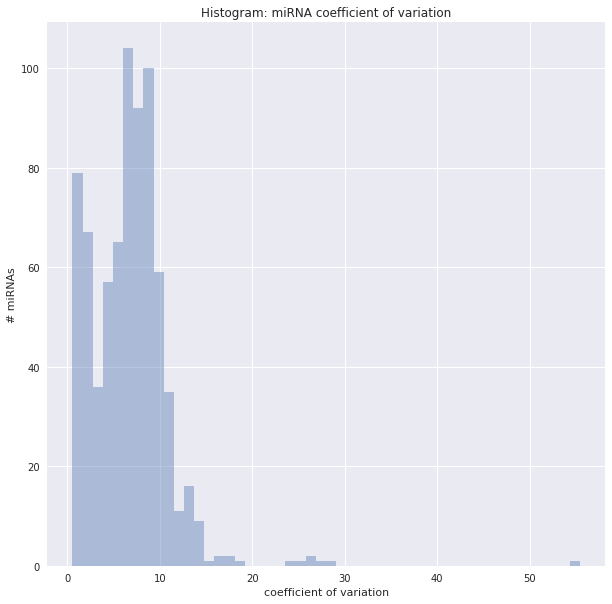

In [196]:
histogram(miRNA_meta['coeff_of_variation'], 10, 10, 'Histogram: miRNA coefficient of variation',
          'coefficient of variation', '# miRNAs', kde=False).savefig('temp.png')
#save_as('temp.png', 'gs://yfl-mirna/explore/miRNA/plots/miRNA-coeff-of-var_histogram.png')

#### Heatmap: coefficient of variation vs. # samples with expression value >= 4

In [135]:
miRNA_meta['samples_gte4_count_sup'] =  miRNA_meta.samples_gte4_count.apply(lambda x: binwidth * m.ceil(x / binwidth))
miRNA_meta['coeff_of_variation_sup'] = miRNA_meta.coeff_of_variation.apply(lambda x: m.ceil(x))
miRNA_meta_crosstab = pd.crosstab(miRNA_meta.samples_gte4_count_sup, miRNA_meta.coeff_of_variation_sup)

In [162]:
miRNA_meta_crosstab_for_heatmap = pd.DataFrame(miRNA_meta_crosstab, miRNA_meta_crosstab.index, range(1, miRNA_meta_crosstab.columns.max() + 1))
for i in range(1, miRNA_meta_crosstab.columns.max() + 1):
  if i not in miRNA_meta_crosstab.columns:
    miRNA_meta_crosstab_for_heatmap[i] = 0
miRNA_meta_crosstab_for_heatmap.reindex_axis(sorted(miRNA_meta_crosstab_for_heatmap.columns), axis=1)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


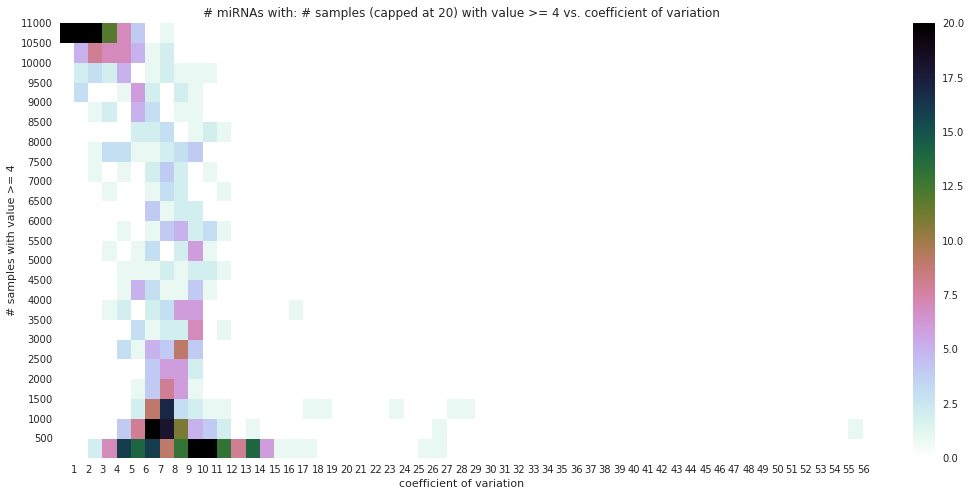

In [195]:
fig = heatmap(miRNA_meta_crosstab_for_heatmap.applymap(lambda x: 20 if x > 20 else x), '# miRNAs (capped at 20) with: # samples with value >= 4 vs. coefficient of variation', 
              'coefficient of variation', '# samples with value >= 4', miRNA_meta_crosstab_for_heatmap.columns, range(1, miRNA_meta_crosstab.index.size + 1),
              miRNA_meta_crosstab_for_heatmap.columns, miRNA_meta_crosstab.index, 18, 8, 'cubehelix_r')
fig.savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRNA/plots/miRNA-samples-gte4_vs_coeff-of-var_heatmap.png')

#### Conclusion
- A decent filter for miRNAs seems to be: >= 500 samples with expression value >= 4, and coefficient of variation >= 1

### Pie-in-the-sky to-dos:
- Pairwise t-tests and Tukey's tests